<pre style="font-size:14px;">
<strong>Dataset Structure and Composition</strong>
This dataset is structured as an image folder dataset, meaning each folder represents a class and contains images of the respective class.
Total Number of Images: 3446
Total Number of Classes: 5
Images per Class: 700
Image Size: 84x84px
<pre>

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
import os
import cv2
import glob as gb
from skimage.filters import gaussian
from skimage.morphology import dilation,erosion
from skimage.feature import canny
from skimage.measure import find_contours
import imutils
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pydot
from keras.utils.vis_utils import plot_model

In [35]:
%matplotlib inline

In [36]:
import zipfile
with zipfile.ZipFile("BCCD.zip","r") as zip_ref:
    zip_ref.extractall("BCCD")

In [7]:
def findedges(image):
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged

In [8]:
def getimageconturs(edged):
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

In [9]:
def getboxes(contours,orig):
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

In [10]:
image_size=(120,120)
code={"basophil":0,"eosinophil":1,"lymphocyte":2,"monocyte":3,"neutrophil":4}
def getcode(n):
    if type(n)==str:
        for x,y in code.items():
            if n==x:
                return y 
    else:
        for x,y in code.items():
            if n==y:
                return x

In [11]:
getcode('eosinophil')

1

In [12]:
def loaddata():
    datasets=r"BCCD\bccd_wbc"
    images=[]
    labels=[]
    count=0
    for category in  os.listdir(datasets):
        categorical_image_path = os.path.join(datasets,category); 
        categorial_images = os.listdir(categorical_image_path);
        print(f"Total image Each {category}=", len(categorial_images))
        label=getcode(category)
        #print(category ,'=>', categorical_image_path,'=>', categorial_images)
        for img in categorial_images:
            full_path =  os.path.join(categorical_image_path,img);
            #Image processing
            image = cv2.imread(full_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # add padding to the image to better detect cell at the edge
            image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])
            
            image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))
            
            # openning errosion then dilation
            kernel = np.ones((3, 3), np.uint8)
            kernel1 = np.ones((5, 5), np.uint8)
            img_erosion = cv2.erode(image1, kernel, iterations=2)
            image1 = cv2.dilate(img_erosion, kernel1, iterations=5)
            
            #detecting the blood cell
            edgedImage = findedges(image1)
            edgedContours = getimageconturs(edgedImage)
            edgedBoxes =  getboxes(edgedContours, image.copy())
            if len(edgedBoxes)==0:
                count +=1
                continue
            # get the large box and get its cordinate
            last = edgedBoxes[-1]
            max_x = int(max(last[:,0]))
            min_x = int( min(last[:,0]))
            max_y = int(max(last[:,1]))
            min_y = int(min(last[:,1]))
            # draw the contour and fill it 
            mask = np.zeros_like(image)
            cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1) 
            # any pixel but the pixels inside the contour is zero
            image[mask==0] = 0
            # extract th blood cell
            image = image[min_y:max_y, min_x:max_x]
            if (np.size(image)==0):
                count +=1
                continue
            # resize th image
            image = cv2.resize(image, image_size)
            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)
            
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')
    return images,labels


In [13]:
images,labels=loaddata()

Total image Each basophil= 700
Total image Each eosinophil= 700
Total image Each lymphocyte= 700
Total image Each monocyte= 700
Total image Each neutrophil= 700


In [14]:
print(f"Total image of bounding box={len(images)}")

Total image of bounding box=3446


In [15]:
images,labels=shuffle(images,labels,random_state=10)

In [16]:
images = images/255
train_image,test_image,train_label,test_label=train_test_split(images,labels,test_size=.2)
test_image,val_image,test_label,val_label=train_test_split(test_image,test_label,test_size=.5)

In [17]:
def displayrandomimage(image,label,typeofimage):
    plt.figure(figsize=(15,15))
    plt.suptitle("some random image of "+typeofimage,fontsize=17)
    for n,i in  enumerate(list(np.random.randint(0,len(image),36))):
        plt.subplot(6,6,n+1)
        plt.imshow(image[i])
        plt.axis("off")
        plt.title(getcode(label[i]))

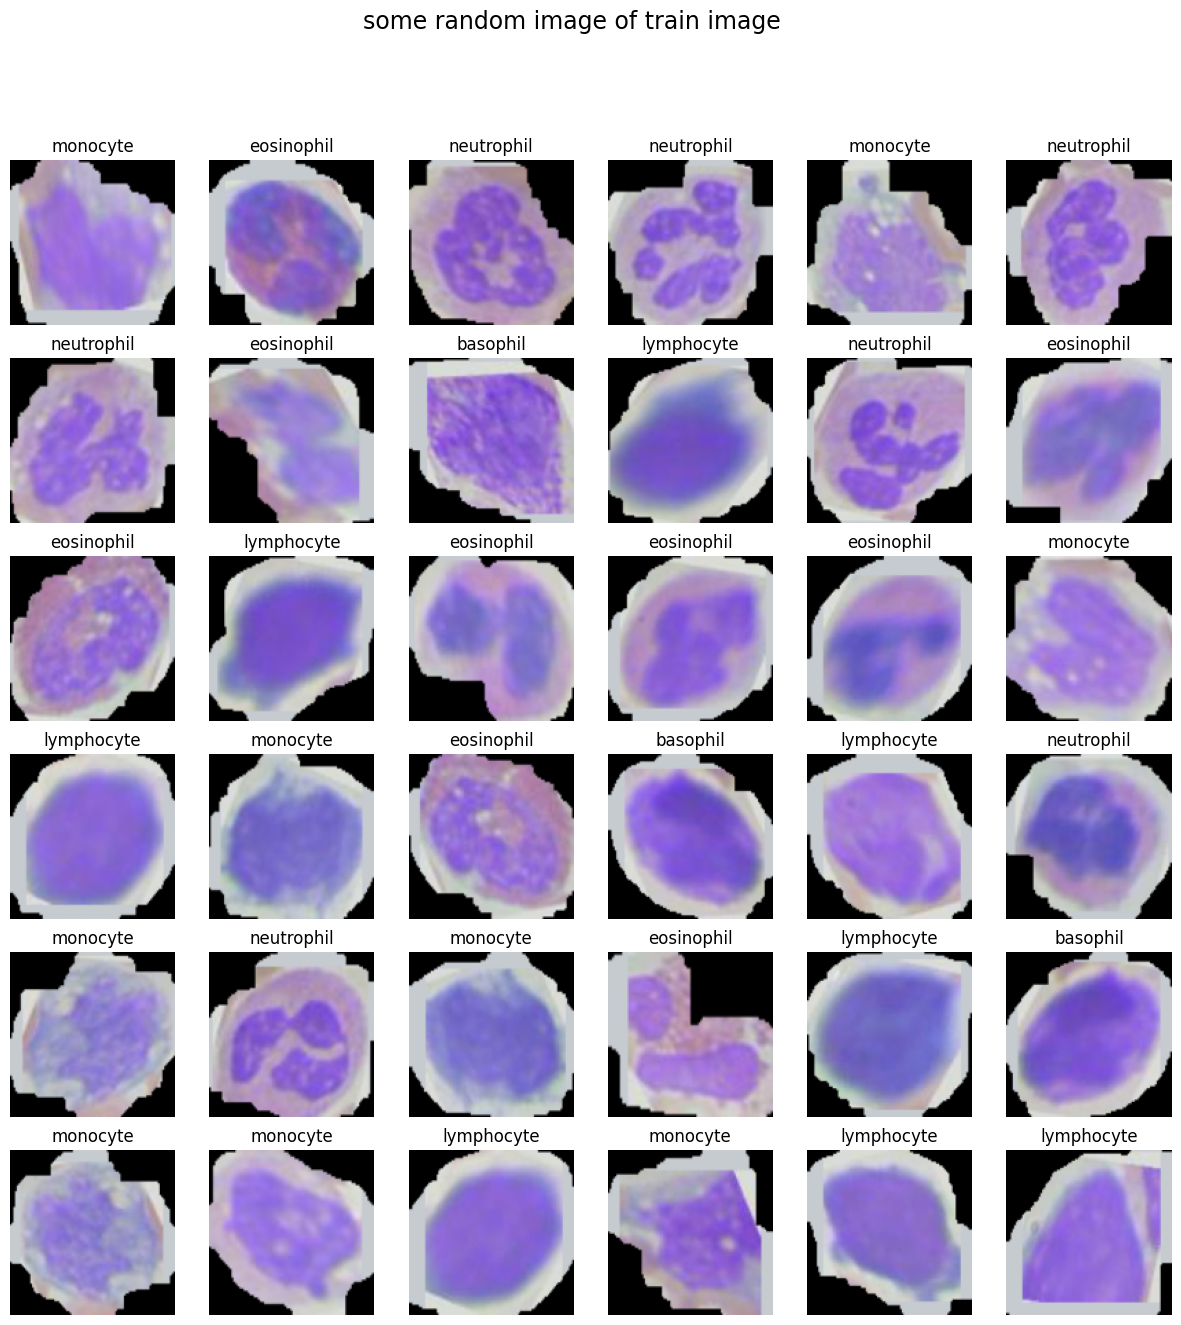

In [18]:
displayrandomimage(train_image,train_label,"train image")

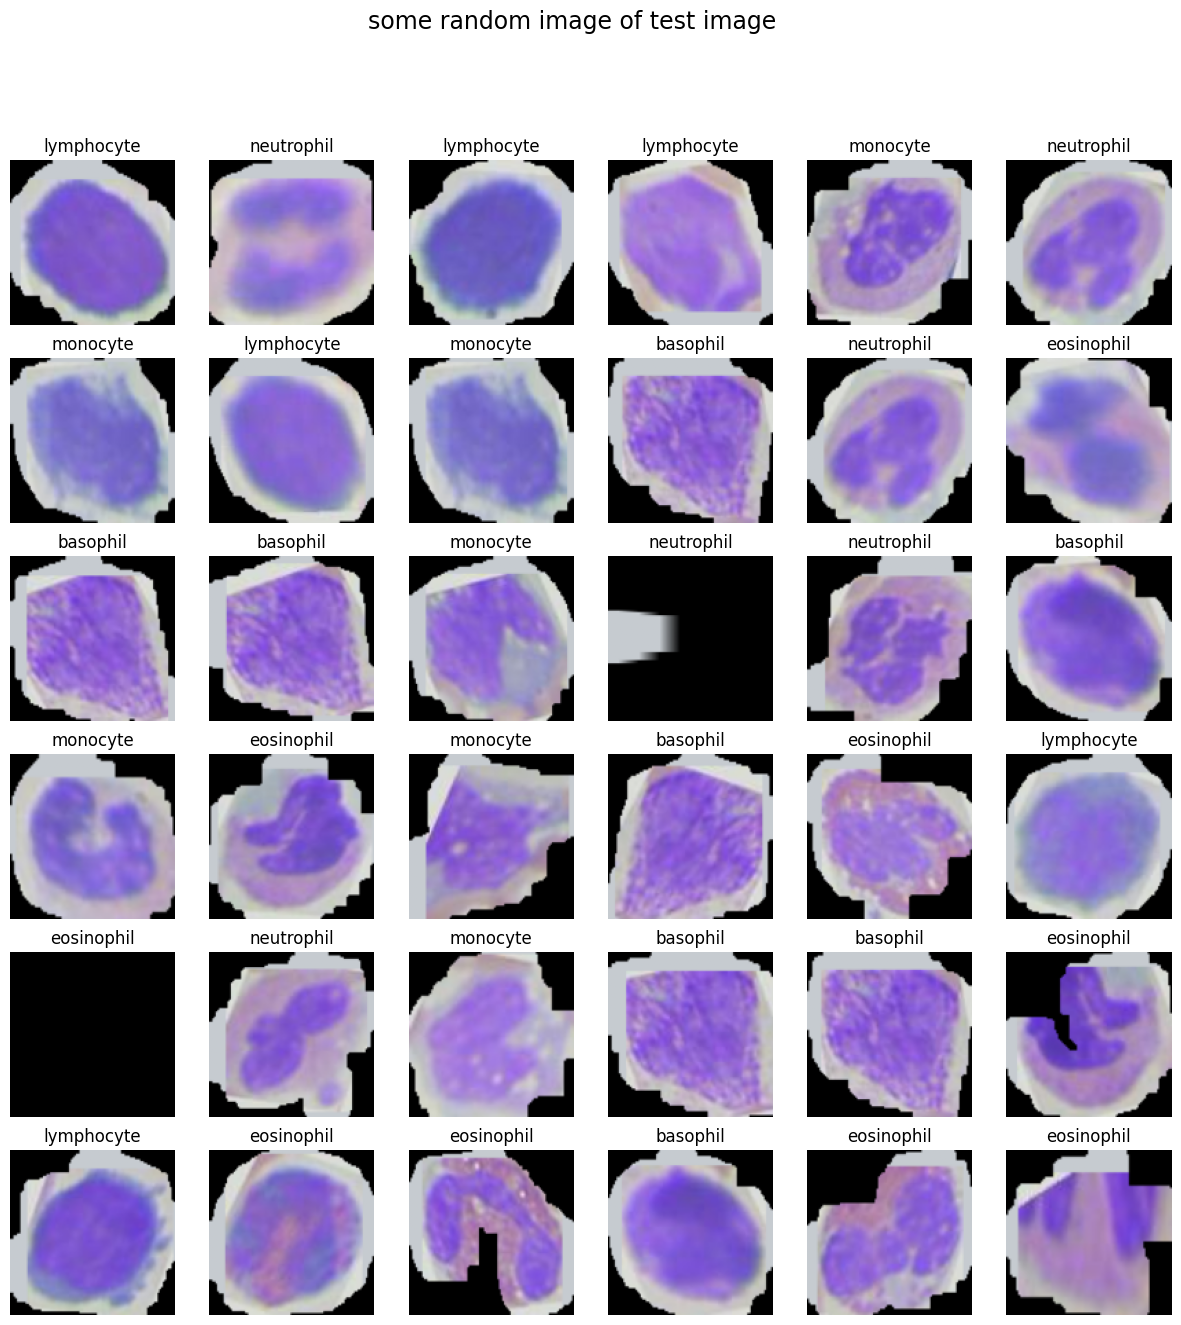

In [19]:
displayrandomimage(test_image,test_label,"test image")

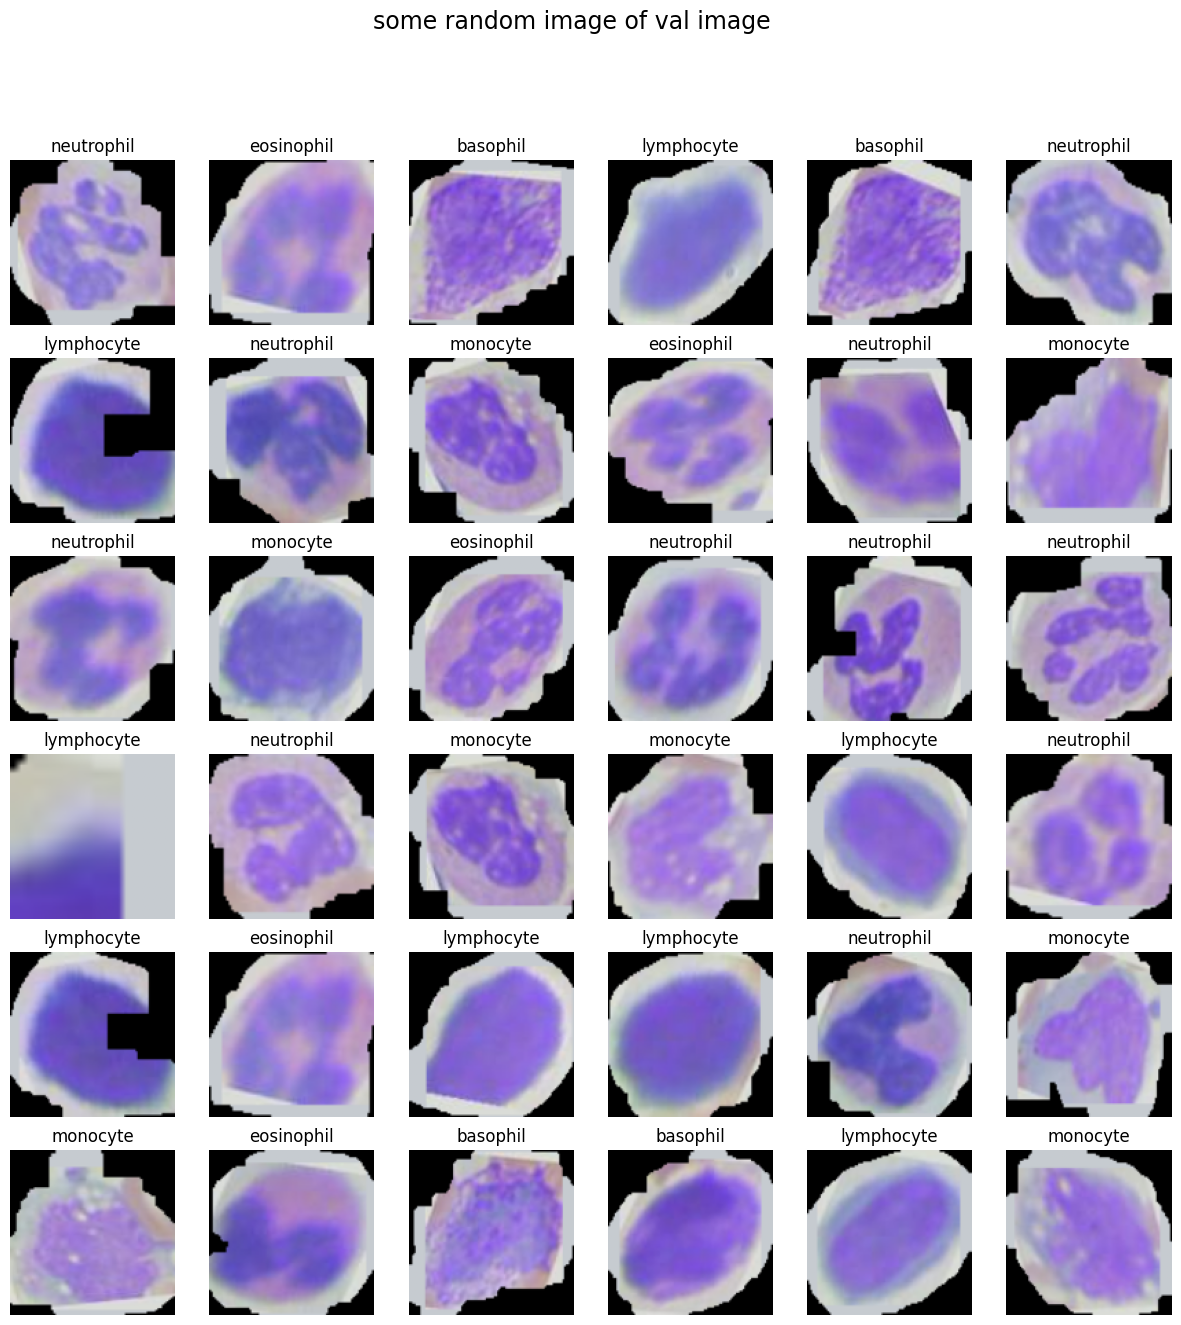

In [20]:
displayrandomimage(val_image,val_label,"val image")

In [21]:
model=keras.models.Sequential([
    keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(120,120,3)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(.25),
    keras.layers.Conv2D(128,(3,3),activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(.25),
    keras.layers.Conv2D(256,(3,3),activation="relu"),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(.25),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    #keras.layers.Dense(2048,activation='relu'),
    keras.layers.Dropout(.25),
    keras.layers.Dense(5,activation='softmax')
])

In [22]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 59, 59, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 128)       0

In [24]:
epochs=30

In [25]:
#Model weights Callcuation
# model.get_weights()

In [26]:
history=model.fit(train_image,
                  train_label,
                  epochs=epochs,
                  batch_size=32,
                  validation_data=(val_image,val_label))

Epoch 1/30
87/87 [==============================] - 110s 1s/step - loss: 1.8442 - accuracy: 0.3153 - val_loss: 1.1374 - val_accuracy: 0.5101
Epoch 2/30
87/87 [==============================] - 106s 1s/step - loss: 0.9812 - accuracy: 0.5958 - val_loss: 0.7244 - val_accuracy: 0.7275
Epoch 3/30
87/87 [==============================] - 101s 1s/step - loss: 0.5998 - accuracy: 0.7504 - val_loss: 0.6370 - val_accuracy: 0.7333
Epoch 4/30
87/87 [==============================] - 102s 1s/step - loss: 0.4306 - accuracy: 0.8208 - val_loss: 0.4754 - val_accuracy: 0.7797
Epoch 5/30
87/87 [==============================] - 102s 1s/step - loss: 0.2791 - accuracy: 0.8824 - val_loss: 0.3438 - val_accuracy: 0.8899
Epoch 6/30
87/87 [==============================] - 103s 1s/step - loss: 0.2236 - accuracy: 0.9057 - val_loss: 0.2861 - val_accuracy: 0.9130
Epoch 7/30
87/87 [==============================] - 105s 1s/step - loss: 0.1620 - accuracy: 0.9390 - val_loss: 0.4170 - val_accuracy: 0.8551
Epoch 8/30
87

In [27]:
loss,acuracy=model.evaluate(test_image,test_label)
print("the accuracy of test image is : ",acuracy)

11/11 [==============================] - 2s 155ms/step - loss: 0.4532 - accuracy: 0.9072
the accuracy of test image is :  0.9072463512420654


In [28]:
def plot_acc_and_loss_of_train_and_val(history):
    #plt.figure(figsize=(15,15))
    #plt.suptitle("acc,loss of train VS acc,loss of val")
    epochs=[i for i in range(30)]
    train_acc=history.history['accuracy']
    train_loss=history.history['loss']
    val_acc=history.history['val_accuracy']
    val_loss=history.history['val_loss']
    fig , ax=plt.subplots(1,2)
    fig.set_size_inches(20,10)
    ax[0].plot(epochs,train_acc,'go-',label='training accuracy')
    ax[0].plot(epochs,val_acc,'ro-',label='validation accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[1].plot(epochs,train_loss,'g-o',label='training loss')
    ax[1].plot(epochs,val_loss,'r-o',label='validation loss')
    ax[1].set_title('Training & Validation loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")

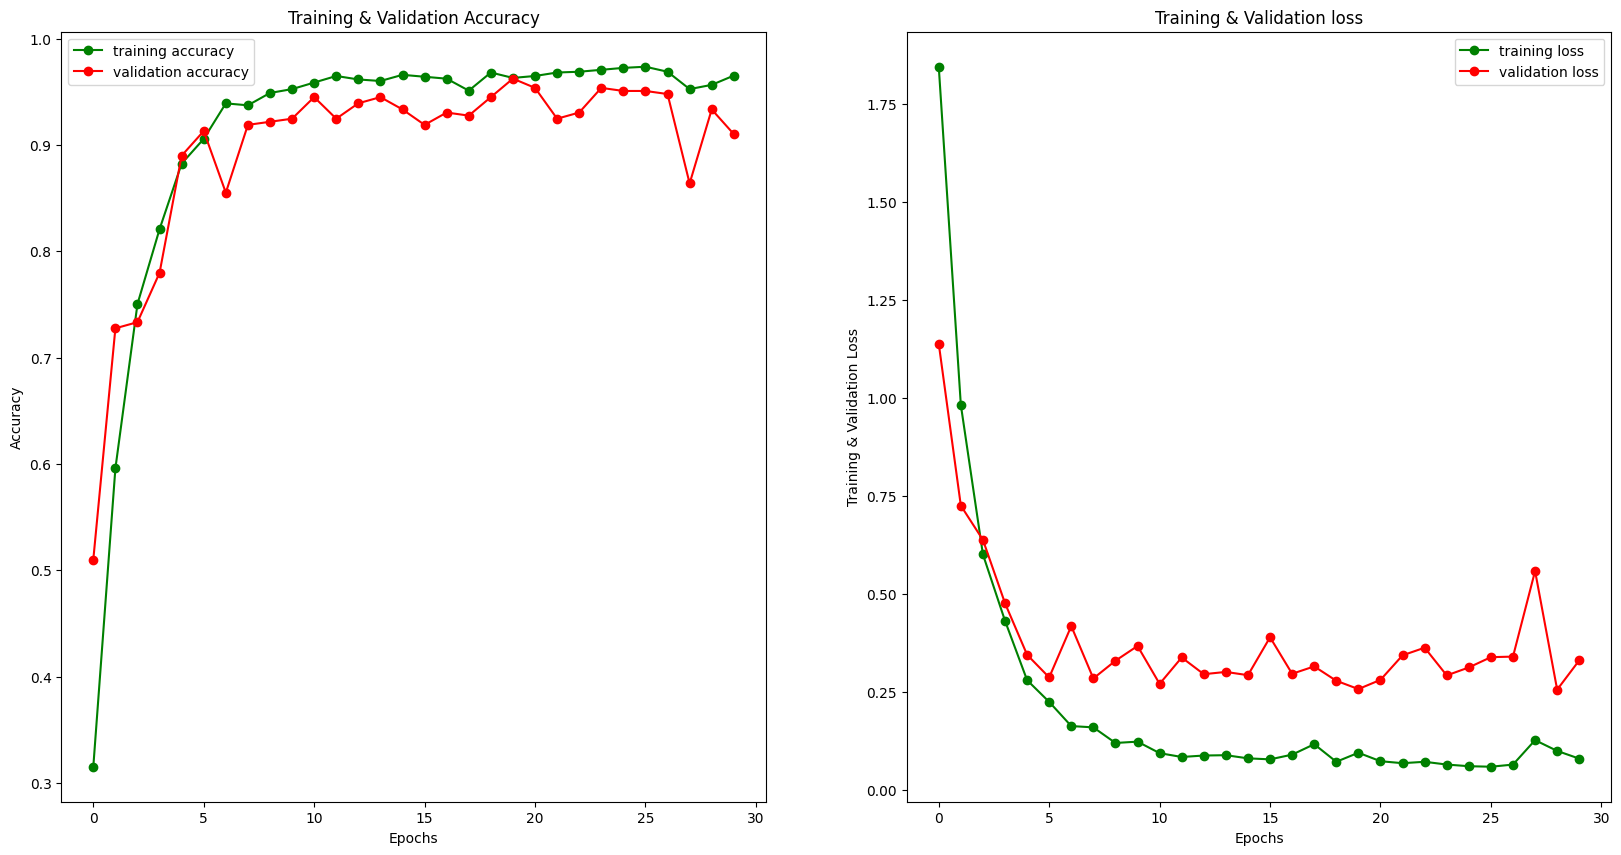

In [29]:
plot_acc_and_loss_of_train_and_val(history)

In [30]:
model.save("CNN_BLOOD_DISEASE")

INFO:tensorflow:Assets written to: CNN_BLOOD_DISEASE\assets


INFO:tensorflow:Assets written to: CNN_BLOOD_DISEASE\assets


In [31]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [37]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
